In [1]:
import numpy as np
import pandas as pd
import uproot
import re
from io import StringIO

import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

## function reading Honda *.d file

### 1) Read the *.d files

In [2]:
def read_honda_flux(path):
    """
    Read a Honda atmospheric neutrino flux .d file and return a tidy DataFrame.

    Returns columns:
      Enu_GeV, NuMu, NuMubar, NuE, NuEbar,
      cosz_low, cosz_high, phi_low, phi_high
    """
    # Header example:
    # average flux in [cosZ = 0.90 --  1.00  phi_Az =   0 --  30]
    hdr_re = re.compile(
        r"cosZ\s*=\s*([-\d.]+)\s*--\s*([-\d.]+).*?"
        r"phi_Az\s*=\s*([-\d.]+)\s*--\s*([-\d.]+)",
        re.IGNORECASE,
    )

    # Numeric line starts with scientific-notation energy
    numline_re = re.compile(r"^\s*[-+]?\d+\.\d+E[-+]\d+")

    blocks = []
    cur_meta = None
    cur_rows = []

    with open(path, "r") as f:
        for line in f:
            line = line.rstrip("\n")

            # New block
            if line.lower().startswith("average flux"):
                if cur_meta is not None and cur_rows:
                    blocks.append((cur_meta, cur_rows))
                cur_rows = []

                m = hdr_re.search(line)
                if not m:
                    raise ValueError(f"Could not parse header line:\n{line}")

                cosz_low, cosz_high, phi_low, phi_high = map(float, m.groups())
                cur_meta = dict(
                    cosz_low=cosz_low,
                    cosz_high=cosz_high,
                    phi_low=phi_low,
                    phi_high=phi_high,
                )
                continue

            # Skip column header line
            if "Enu" in line and "NuMu" in line:
                continue

            # Keep numeric data lines only
            if numline_re.match(line):
                parts = line.split()
                if len(parts) < 5:
                    continue
                cur_rows.append([float(x) for x in parts[:5]])

    # Flush final block
    if cur_meta is not None and cur_rows:
        blocks.append((cur_meta, cur_rows))

    # Assemble DataFrame
    dfs = []
    for meta, rows in blocks:
        arr = np.asarray(rows, dtype=float)
        dfb = pd.DataFrame(
            arr,
            columns=["Enu_GeV", "NuMu", "NuMubar", "NuE", "NuEbar"],
        )
        for k, v in meta.items():
            dfb[k] = v
        dfs.append(dfb)

    if not dfs:
        raise RuntimeError(f"No flux blocks found in {path}")

    return pd.concat(dfs, ignore_index=True)


In [3]:
## the flux files are downloaded from http://www-rccn.icrr.u-tokyo.ac.jp/mhonda/public/nflx2014/index.html
ang_avg_homestake_solar_max = read_honda_flux("/Users/sungbino/OneDrive/OneDrive/SBND/sbnd_dune_phase_space/flux/atm/Honda/hms-ally-01-01-solmax.d")
ang_avg_homestake_solar_min = read_honda_flux("/Users/sungbino/OneDrive/OneDrive/SBND/sbnd_dune_phase_space/flux/atm/Honda/hms-ally-01-01-solmin.d")

In [4]:
ang_avg_homestake_solar_max

,Enu_GeV,NuMu,NuMubar,NuE,NuEbar,cosz_low,cosz_high,phi_low,phi_high
0,0.10000,1.412800e+04,1.434400e+04,6.855500e+03,6.565900e+03,-1.0,1.0,0.0,360.0
1,0.11220,1.214100e+04,1.228200e+04,5.956200e+03,5.654100e+03,-1.0,1.0,0.0,360.0
2,0.12589,1.038600e+04,1.047300e+04,5.116900e+03,4.813800e+03,-1.0,1.0,0.0,360.0
3,0.14125,8.829400e+03,8.873300e+03,4.356000e+03,4.054400e+03,-1.0,1.0,0.0,360.0
4,0.15849,7.437800e+03,7.450500e+03,3.679900e+03,3.384100e+03,-1.0,1.0,0.0,360.0
...,...,...,...,...,...,...,...,...,...
96,6309.60000,5.608200e-10,3.205900e-10,1.824700e-11,1.320400e-11,-1.0,1.0,0.0,360.0
97,7079.50000,3.755000e-10,2.133900e-10,1.198500e-11,8.679800e-12,-1.0,1.0,0.0,360.0
98,7943.30000,2.508900e-10,1.416400e-10,7.859100e-12,5.686400e-12,-1.0,1.0,0.0,360.0
99,8912.50000,1.672300e-10,9.375000e-11,5.179000e-12,3.718000e-12,-1.0,1.0,0.0,360.0


In [5]:
ang_avg_homestake_solar_min

,Enu_GeV,NuMu,NuMubar,NuE,NuEbar,cosz_low,cosz_high,phi_low,phi_high
0,0.10000,1.667600e+04,1.691500e+04,8.218600e+03,7.609500e+03,-1.0,1.0,0.0,360.0
1,0.11220,1.427300e+04,1.443200e+04,7.117400e+03,6.532700e+03,-1.0,1.0,0.0,360.0
2,0.12589,1.216200e+04,1.225900e+04,6.091300e+03,5.542700e+03,-1.0,1.0,0.0,360.0
3,0.14125,1.029600e+04,1.034300e+04,5.162800e+03,4.650600e+03,-1.0,1.0,0.0,360.0
4,0.15849,8.633900e+03,8.645800e+03,4.341100e+03,3.865900e+03,-1.0,1.0,0.0,360.0
...,...,...,...,...,...,...,...,...,...
96,6309.60000,5.608200e-10,3.205900e-10,1.824700e-11,1.320400e-11,-1.0,1.0,0.0,360.0
97,7079.50000,3.755000e-10,2.133900e-10,1.198500e-11,8.679800e-12,-1.0,1.0,0.0,360.0
98,7943.30000,2.508900e-10,1.416400e-10,7.859100e-12,5.686400e-12,-1.0,1.0,0.0,360.0
99,8912.50000,1.672300e-10,9.375000e-11,5.179000e-12,3.718000e-12,-1.0,1.0,0.0,360.0


### 2) Make splins for the flux to produce flux arrays with linear E_nu spacing

In [6]:
def make_flux_array(flux_df):
    Enu = flux_df.Enu_GeV
    numu_flux = flux_df.NuMu
    numubar_flux = flux_df.NuMubar
    nue_flux = flux_df.NuE
    nuebar_flux = flux_df.NuEbar

    numu_spline = CubicSpline(Enu, numu_flux)
    numubar_spline = CubicSpline(Enu, numubar_flux)
    nue_spline = CubicSpline(Enu, nue_flux)
    nuebar_spline = CubicSpline(Enu, nuebar_flux)

    ## make linear space flux arrays from 0.1 GeV to 20 GeV
    N_bins = 9950 ## this is for 0.002 GeV bin width
    Enu_lin = np.linspace(0.1 + (20. - 0.1) / (2.*N_bins), 20 + (20. -0.1) / (2. * N_bins), N_bins + 1) ## shifting by half bin width to get bin center values
    numu_flux_lin = numu_spline(Enu_lin)
    numubar_flux_lin = numubar_spline(Enu_lin)
    nue_flux_lin = nue_spline(Enu_lin)
    nuebar_flux_lin = nuebar_spline(Enu_lin)

    # return the linear space arrays
    return Enu_lin, numu_flux_lin, numubar_flux_lin, nue_flux_lin, nuebar_flux_lin

In [7]:
flux_arr_solar_max = make_flux_array(ang_avg_homestake_solar_max)
flux_arr_solar_min = make_flux_array(ang_avg_homestake_solar_min)

### 3) Plot the linear flux arrays

In [8]:
def plot_E_nu_vs_flux(flux_arr, title):
    Enu_lin, numu_flux_lin, numubar_flux_lin, nue_flux_lin, nuebar_flux_lin = flux_arr

    plt.figure(figsize=(10, 6))
    plt.plot(Enu_lin, numu_flux_lin, label='NuMu Flux', color='blue')
    plt.plot(Enu_lin, numubar_flux_lin, label='NuMubar Flux', color='red')
    plt.plot(Enu_lin, nue_flux_lin, label='NuE Flux', color='green')
    plt.plot(Enu_lin, nuebar_flux_lin, label='NuEbar Flux', color='orange')

    plt.yscale('log')
    plt.xlabel('Neutrino Energy (GeV)')
    plt.ylabel('Flux (units)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

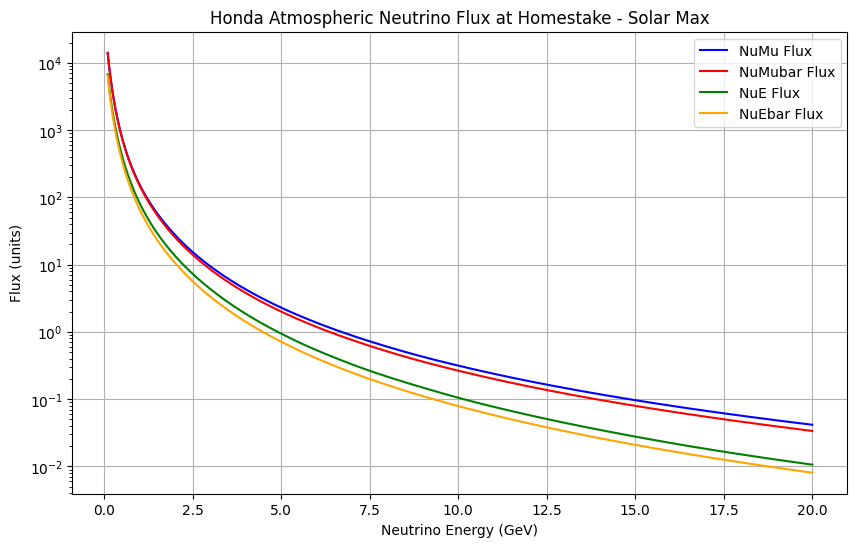

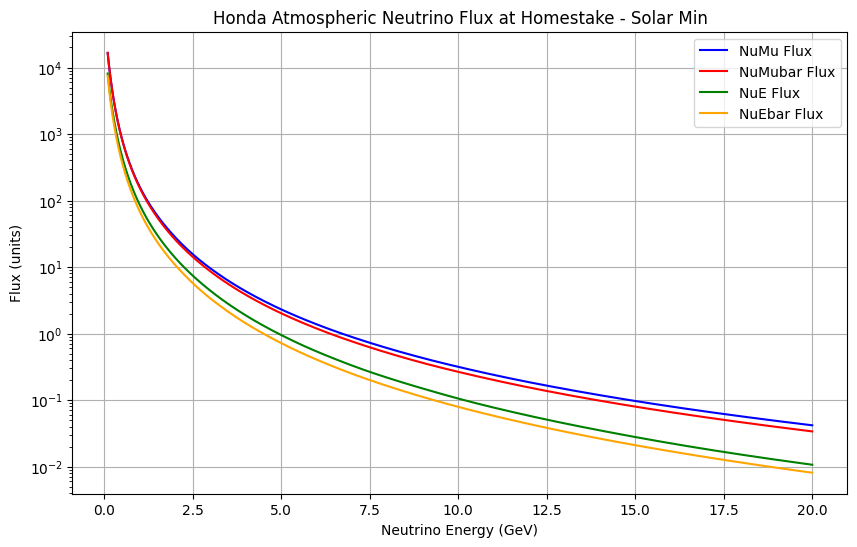

In [9]:
plot_E_nu_vs_flux(flux_arr_solar_max, "Honda Atmospheric Neutrino Flux at Homestake - Solar Max")
plot_E_nu_vs_flux(flux_arr_solar_min, "Honda Atmospheric Neutrino Flux at Homestake - Solar Min")

### 4) Save the flux into ROOT file as TH1D

In [10]:
def save_flux_to_root(flux_data, filename="honda_homestake_solar_max.root"):
    # centers is index 0 (length 200)
    centers = np.array(flux_data[0])
    flavors = ["numu", "numubar", "nue", "nuebar"]
    
    # 1. Calculate the uniform bin width
    # In uniform binning, any two adjacent centers give the width
    bin_width = centers[1] - centers[0]
    
    # 2. Create the edges array (length 201)
    # The first edge is half a width below the first center
    start_edge = centers[0] - (bin_width / 2.0)
    # The last edge is half a width above the last center
    end_edge = centers[-1] + (bin_width / 2.0)
    
    # Generate 201 evenly spaced edges from start to end
    edges = np.linspace(start_edge, end_edge, len(centers) + 1)

    with uproot.recreate(filename) as f:
        for i, name in enumerate(flavors, start=1):
            flux_values = np.array(flux_data[i])
            
            # Write as TH1D: (counts, edges)
            f[name] = (flux_values, edges)
            
    print(f"File '{filename}' created successfully.")
    print(f"Bin width: {bin_width:.4f}, Range: [{edges[0]:.2f}, {edges[-1]:.2f}]")

In [11]:
save_flux_to_root(flux_arr_solar_max, filename="honda_homestake_solar_max_linear.root")
save_flux_to_root(flux_arr_solar_min, filename="honda_homestake_solar_min_linear.root")

File 'honda_homestake_solar_max_linear.root' created successfully.
Bin width: 0.0020, Range: [0.10, 20.00]
File 'honda_homestake_solar_min_linear.root' created successfully.
Bin width: 0.0020, Range: [0.10, 20.00]


## E_nu < 100 MeV region

Tables 2 - 5 from Astropart.Phys. 23 (2005) 526-534

### 1) raw texts of the tables copied from https://www.sciencedirect.com/science/article/pii/S0927650505000526#tbl3

In [12]:
raw_table_2="""0.013	0.114E+06 ± 0.994E+03	0.116E+06 ± 0.656E+03
0.015	0.124E+06 ± 0.710E+03	0.128E+06 ± 0.792E+03
0.017	0.138E+06 ± 0.788E+03	0.136E+06 ± 0.522E+03
0.019	0.146E+06 ± 0.596E+03	0.150E+06 ± 0.490E+03
0.021	0.155E+06 ± 0.644E+03	0.158E+06 ± 0.600E+03
0.024	0.159E+06 ± 0.540E+03	0.162E+06 ± 0.407E+03
0.027	0.164E+06 ± 0.591E+03	0.170E+06 ± 0.500E+03
0.030	0.181E+06 ± 0.576E+03	0.196E+06 ± 0.774E+03
0.033	0.174E+06 ± 0.420E+03	0.177E+06 ± 0.495E+03
0.038	0.179E+06 ± 0.829E+03	0.182E+06 ± 0.505E+03
0.042	0.178E+06 ± 0.537E+03	0.183E+06 ± 0.537E+03
0.047	0.176E+06 ± 0.269E+03	0.181E+06 ± 0.437E+03
0.053	0.153E+06 ± 0.395E+03	0.155E+06 ± 0.334E+03
0.060	0.131E+06 ± 0.237E+03	0.132E+06 ± 0.372E+03
0.067	0.123E+06 ± 0.635E+03	0.123E+06 ± 0.415E+03
0.075	0.114E+06 ± 0.310E+03	0.112E+06 ± 0.218E+03
0.084	0.107E+06 ± 0.152E+03	0.101E+06 ± 0.220E+03
0.094	0.963E+05 ± 0.218E+03	0.921E+05 ± 0.239E+03
0.106	0.842E+05 ± 0.203E+03	0.822E+05 ± 0.187E+03
0.119	0.727E+05 ± 0.145E+03	0.725E+05 ± 0.110E+03
0.133	0.635E+05 ± 0.187E+03	0.640E+05 ± 0.158E+03
0.150	0.552E+05 ± 0.125E+03	0.556E+05 ± 0.112E+03
0.168	0.477E+05 ± 0.878E+02	0.476E+05 ± 0.942E+02
0.188	0.412E+05 ± 0.245E+03	0.408E+05 ± 0.102E+03
0.211	0.344E+05 ± 0.827E+02	0.341E+05 ± 0.880E+02
0.237	0.284E+05 ± 0.558E+02	0.286E+05 ± 0.610E+02
0.266	0.236E+05 ± 0.762E+02	0.235E+05 ± 0.516E+02
0.299	0.196E+05 ± 0.412E+02	0.193E+05 ± 0.336E+02
0.335	0.158E+05 ± 0.395E+02	0.157E+05 ± 0.363E+02
0.376	0.128E+05 ± 0.348E+02	0.126E+05 ± 0.238E+02
0.422	0.103E+05 ± 0.276E+02	0.102E+05 ± 0.268E+02
0.473	0.820E+04 ± 0.162E+02	0.815E+04 ± 0.216E+02
0.531	0.649E+04 ± 0.121E+02	0.648E+04 ± 0.309E+02
0.596	0.515E+04 ± 0.128E+02	0.502E+04 ± 0.115E+02
0.668	0.398E+04 ± 0.109E+02	0.394E+04 ± 0.117E+02
0.750	0.313E+04 ± 0.150E+02	0.303E+04 ± 0.935E+01
0.841	0.241E+04 ± 0.626E+01	0.233E+04 ± 0.921E+02
0.944	0.182E+04 ± 0.548E+01	0.179E+04 ± 0.428E+01"""

raw_table_3="""0.013	0.696E+05 ± 0.695E+03	0.637E+05 ± 0.377E+03
0.015	0.746E+05 ± 0.435E+03	0.697E+05 ± 0.453E+03
0.017	0.797E+05 ± 0.384E+03	0.795E+05 ± 0.114E+04
0.019	0.874E+05 ± 0.419E+03	0.842E+05 ± 0.461E+03
0.021	0.942E+05 ± 0.429E+03	0.894E+05 ± 0.355E+03
0.024	0.101E+06 ± 0.149E+04	0.950E+05 ± 0.878E+03
0.027	0.103E+06 ± 0.364E+03	0.993E+05 ± 0.535E+03
0.030	0.109E+06 ± 0.690E+03	0.103E+06 ± 0.371E+03
0.033	0.108E+06 ± 0.361E+03	0.104E+06 ± 0.470E+03
0.038	0.107E+06 ± 0.354E+03	0.101E+06 ± 0.330E+03
0.042	0.101E+06 ± 0.376E+03	0.961E+05 ± 0.288E+03
0.047	0.885E+05 ± 0.341E+03	0.835E+05 ± 0.291E+03
0.053	0.696E+05 ± 0.202E+03	0.659E+05 ± 0.204E+03
0.060	0.644E+05 ± 0.200E+03	0.600E+05 ± 0.260E+03
0.067	0.593E+05 ± 0.198E+03	0.564E+05 ± 0.212E+03
0.075	0.543E+05 ± 0.145E+03	0.514E+05 ± 0.137E+03
0.084	0.497E+05 ± 0.105E+03	0.463E+05 ± 0.177E+03
0.094	0.451E+05 ± 0.124E+03	0.430E+05 ± 0.480E+03
0.106	0.406E+05 ± 0.118E+03	0.372E+05 ± 0.121E+03
0.119	0.358E+05 ± 0.972E+02	0.329E+05 ± 0.875E+02
0.133	0.317E+05 ± 0.199E+03	0.288E+05 ± 0.951E+02
0.150	0.273E+05 ± 0.680E+02	0.249E+05 ± 0.777E+02
0.168	0.239E+05 ± 0.549E+02	0.213E+05 ± 0.648E+02
0.188	0.204E+05 ± 0.104E+03	0.183E+05 ± 0.440E+02
0.211	0.170E+05 ± 0.457E+02	0.154E+05 ± 0.412E+02
0.237	0.145E+05 ± 0.951E+02	0.129E+05 ± 0.445E+02
0.266	0.120E+05 ± 0.338E+02	0.106E+05 ± 0.315E+02
0.299	0.996E+04 ± 0.293E+02	0.880E+04 ± 0.251E+02
0.335	0.811E+04 ± 0.276E+02	0.713E+04 ± 0.151E+02
0.376	0.662E+04 ± 0.172E+02	0.575E+04 ± 0.248E+02
0.422	0.527E+04 ± 0.124E+02	0.460E+04 ± 0.192E+02
0.473	0.423E+04 ± 0.114E+02	0.368E+04 ± 0.119E+02
0.531	0.337E+04 ± 0.313E+02	0.288E+04 ± 0.111E+02
0.596	0.266E+04 ± 0.790E+01	0.228E+04 ± 0.698E+01
0.668	0.209E+04 ± 0.693E+01	0.187E+04 ± 0.414E+02
0.750	0.162E+04 ± 0.537E+01	0.137E+04 ± 0.431E+01
0.841	0.124E+04 ± 0.424E+01	0.106E+04 ± 0.485E+01
0.944	0.950E+03 ± 0.339E+01	0.800E+03 ± 0.249E+01"""

raw_table_4="""0.013	0.174E+06 ± 0.114E+04	0.173E+06 ± 0.789E+03
0.015	0.190E+06 ± 0.114E+04	0.194E+06 ± 0.115E+04
0.017	0.211E+06 ± 0.998E+03	0.211E+06 ± 0.263E+04
0.019	0.220E+06 ± 0.794E+03	0.226E+06 ± 0.801E+03
0.021	0.235E+06 ± 0.898E+03	0.241E+06 ± 0.103E+04
0.024	0.243E+06 ± 0.940E+03	0.247E+06 ± 0.733E+03
0.027	0.248E+06 ± 0.736E+03	0.260E+06 ± 0.895E+03
0.030	0.275E+06 ± 0.108E+04	0.299E+06 ± 0.985E+03
0.033	0.263E+06 ± 0.610E+03	0.269E+06 ± 0.527E+03
0.038	0.270E+06 ± 0.105E+04	0.276E+06 ± 0.789E+03
0.042	0.269E+06 ± 0.730E+03	0.279E+06 ± 0.928E+03
0.047	0.266E+06 ± 0.475E+03	0.276E+06 ± 0.743E+03
0.053	0.232E+06 ± 0.605E+03	0.233E+06 ± 0.476E+03
0.060	0.197E+06 ± 0.422E+03	0.199E+06 ± 0.604E+03
0.067	0.182E+06 ± 0.723E+03	0.184E+06 ± 0.531E+03
0.075	0.169E+06 ± 0.450E+03	0.166E+06 ± 0.275E+03
0.084	0.157E+06 ± 0.283E+03	0.149E+06 ± 0.308E+03
0.094	0.141E+06 ± 0.299E+03	0.137E+06 ± 0.465E+03
0.106	0.123E+06 ± 0.310E+03	0.119E+06 ± 0.258E+03
0.119	0.105E+06 ± 0.230E+03	0.105E+06 ± 0.205E+03
0.133	0.912E+05 ± 0.240E+03	0.915E+05 ± 0.219E+03
0.150	0.785E+05 ± 0.152E+03	0.790E+05 ± 0.156E+03
0.168	0.672E+05 ± 0.134E+03	0.675E+05 ± 0.162E+03
0.188	0.575E+05 ± 0.265E+03	0.572E+05 ± 0.146E+03
0.211	0.476E+05 ± 0.107E+03	0.474E+05 ± 0.118E+03
0.237	0.391E+05 ± 0.831E+02	0.394E+05 ± 0.855E+02
0.266	0.325E+05 ± 0.150E+03	0.321E+05 ± 0.741E+02
0.299	0.262E+05 ± 0.442E+02	0.260E+05 ± 0.408E+02
0.335	0.212E+05 ± 0.630E+02	0.209E+05 ± 0.447E+02
0.376	0.169E+05 ± 0.451E+02	0.166E+05 ± 0.335E+02
0.422	0.134E+05 ± 0.322E+02	0.133E+05 ± 0.358E+02
0.473	0.105E+05 ± 0.209E+02	0.105E+05 ± 0.290E+02
0.531	0.825E+04 ± 0.173E+02	0.821E+04 ± 0.312E+02
0.596	0.640E+04 ± 0.147E+02	0.629E+04 ± 0.147E+02
0.668	0.490E+04 ± 0.145E+02	0.488E+04 ± 0.162E+02
0.750	0.378E+04 ± 0.156E+02	0.371E+04 ± 0.117E+02
0.841	0.287E+04 ± 0.716E+01	0.281E+04 ± 0.102E+02
0.944	0.214E+04 ± 0.727E+01	0.211E+04 ± 0.497E+01"""

raw_table_5="""0.013	0.105E+06 ± 0.893E+03	0.964E+05 ± 0.650E+03
0.015	0.114E+06 ± 0.632E+03	0.105E+06 ± 0.698E+03
0.017	0.121E+06 ± 0.681E+03	0.117E+06 ± 0.114E+04
0.019	0.133E+06 ± 0.967E+03	0.124E+06 ± 0.584E+03
0.021	0.140E+06 ± 0.620E+03	0.133E+06 ± 0.473E+03
0.024	0.152E+06 ± 0.152E+04	0.142E+06 ± 0.938E+03
0.027	0.158E+06 ± 0.751E+03	0.147E+06 ± 0.590E+03
0.030	0.165E+06 ± 0.763E+03	0.153E+06 ± 0.510E+03
0.033	0.164E+06 ± 0.483E+03	0.153E+06 ± 0.664E+03
0.038	0.161E+06 ± 0.455E+03	0.153E+06 ± 0.740E+03
0.042	0.153E+06 ± 0.503E+03	0.143E+06 ± 0.414E+03
0.047	0.134E+06 ± 0.419E+03	0.125E+06 ± 0.593E+03
0.053	0.105E+06 ± 0.286E+03	0.978E+05 ± 0.347E+03
0.060	0.960E+05 ± 0.315E+03	0.886E+05 ± 0.365E+03
0.067	0.885E+05 ± 0.223E+03	0.823E+05 ± 0.324E+03
0.075	0.808E+05 ± 0.213E+03	0.748E+05 ± 0.182E+03
0.084	0.735E+05 ± 0.248E+03	0.670E+05 ± 0.190E+03
0.094	0.671E+05 ± 0.325E+03	0.612E+05 ± 0.486E+03
0.106	0.595E+05 ± 0.172E+03	0.531E+05 ± 0.162E+03
0.119	0.519E+05 ± 0.139E+03	0.466E+05 ± 0.106E+03
0.133	0.457E+05 ± 0.228E+03	0.406E+05 ± 0.127E+03
0.150	0.394E+05 ± 0.150E+03	0.347E+05 ± 0.909E+02
0.168	0.340E+05 ± 0.912E+02	0.295E+05 ± 0.872E+02
0.188	0.292E+05 ± 0.109E+03	0.253E+05 ± 0.971E+02
0.211	0.241E+05 ± 0.746E+02	0.211E+05 ± 0.851E+02
0.237	0.203E+05 ± 0.103E+03	0.176E+05 ± 0.632E+02
0.266	0.168E+05 ± 0.561E+02	0.143E+05 ± 0.437E+02
0.299	0.140E+05 ± 0.202E+03	0.118E+05 ± 0.365E+02
0.335	0.110E+05 ± 0.412E+02	0.943E+04 ± 0.225E+02
0.376	0.894E+04 ± 0.267E+02	0.758E+04 ± 0.264E+02
0.422	0.706E+04 ± 0.218E+02	0.595E+04 ± 0.226E+02
0.473	0.557E+04 ± 0.154E+02	0.467E+04 ± 0.185E+02
0.531	0.445E+04 ± 0.341E+02	0.364E+04 ± 0.132E+02
0.596	0.344E+04 ± 0.130E+02	0.284E+04 ± 0.906E+01
0.668	0.267E+04 ± 0.915E+01	0.226E+04 ± 0.413E+02
0.750	0.211E+04 ± 0.233E+02	0.168E+04 ± 0.819E+01
0.841	0.153E+04 ± 0.596E+01	0.127E+04 ± 0.716E+01
0.944	0.116E+04 ± 0.391E+01	0.938E+03 ± 0.380E+01"""

### 2) Convert the raw texts to data frames

In [13]:
def parse_raw_table_to_df(raw_text, columns=['Energy_GeV', 'numu', 'numu_err', 'numubar', 'numubar_err']):
    """
    Parses the specific scientific notation string format:
    Energy | flux1 ± error | flux2 ± error
    """
    # Regex to find: (Energy) (Flux1) ± (Err1) (Flux2) ± (Err2)
    pattern = r"(\d+\.\d+)\s*(\d+\.\d+E[+-]\d+)\s*±\s*(\d+\.\d+E[+-]\d+)\s*(\d+\.\d+E[+-]\d+)\s*±\s*(\d+\.\d+E[+-]\d+)"
    
    matches = re.findall(pattern, raw_text)
    
    # Create DataFrame
    df = pd.DataFrame(matches, columns=columns)
    
    # Convert columns to numeric floats
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
        
    return df

table 2: Kamioka solar avg, numu & numubar

table 3: Kamioka solar avg, nue & nuebar

table 4: Gran Sasso solar avg, numu & numubar

table 5: Gran Sasso solar avg, nue & nuebar

In [14]:
kamioka_solar_avg_numu_numubar_df = parse_raw_table_to_df(raw_table_2)
kamioka_solar_avg_nue_nuebar_df = parse_raw_table_to_df(raw_table_3, columns=['Energy_GeV', 'nue', 'nue_err', 'nuebar', 'nuebar_err'])
gransasso_solar_max_numu_numubar_df = parse_raw_table_to_df(raw_table_4)
gransasso_solar_max_nue_nuebar_df = parse_raw_table_to_df(raw_table_5, columns=['Energy_GeV', 'nue', 'nue_err', 'nuebar', 'nuebar_err'])

### 3) Make splines for the flux

In [15]:
def make_flux_array_lowE(df, colx, coly):
    spline = CubicSpline(df[colx], df[coly])

    ## make linear space flux arrays from 0.015 GeV to 0.940 GeV
    N_bins = 462 ## this is for 0.002 GeV bin width
    Enu_lin = np.linspace(0.015 + (0.940 - 0.015) / (2.*N_bins), 0.940 + (0.940 -0.015) / (2. * N_bins), N_bins + 1) ## shifting by half bin width to get bin center values
    flux_lin = spline(Enu_lin)
    return Enu_lin, flux_lin

In [16]:
flux_kamioka_numu = make_flux_array_lowE(kamioka_solar_avg_numu_numubar_df, 'Energy_GeV', 'numu')
flux_kamioka_numubar = make_flux_array_lowE(kamioka_solar_avg_numu_numubar_df, 'Energy_GeV', 'numubar')
flux_kamioka_nue = make_flux_array_lowE(kamioka_solar_avg_nue_nuebar_df, 'Energy_GeV', 'nue')
flux_kamioka_nuebar = make_flux_array_lowE(kamioka_solar_avg_nue_nuebar_df, 'Energy_GeV', 'nuebar')

flux_gransasso_numu = make_flux_array_lowE(gransasso_solar_max_numu_numubar_df, 'Energy_GeV', 'numu')
flux_gransasso_numubar = make_flux_array_lowE(gransasso_solar_max_numu_numubar_df, 'Energy_GeV', 'numubar')
flux_gransasso_nue = make_flux_array_lowE(gransasso_solar_max_nue_nuebar_df, 'Energy_GeV', 'nue')
flux_gransasso_nuebar = make_flux_array_lowE(gransasso_solar_max_nue_nuebar_df, 'Energy_GeV', 'nuebar')

### 4) Plot the fluxes

In [17]:
def plot_lowE_and_highE(low_E1, lowE2, high_E_solar_max_E, high_E_solar_max_flux, high_E_solar_min_E, high_E_solar_min_flux, flavor, lowE_det1="Kamioka", lowE_det2="Gran Sasso"):
    Enu_low1, flux_low1 = low_E1
    Enu_low2, flux_low2 = lowE2
    Enu_high_max, flux_high_max = high_E_solar_max_E, high_E_solar_max_flux
    Enu_high_min, flux_high_min = high_E_solar_min_E, high_E_solar_min_flux
    plt.figure(figsize=(10, 6))
    plt.plot(Enu_low1, flux_low1, label=f'{flavor} Flux Astropart.Phys. 23 (2005) 526-534, {lowE_det1} solar avg.', color='blue')
    plt.plot(Enu_low2, flux_low2, label=f'{flavor} Flux Astropart.Phys. 23 (2005) 526-534, {lowE_det2} solar avg.', color='cyan')
    plt.plot(Enu_high_max, flux_high_max, label=f'{flavor} Honda SURF Solar Max', color='red')
    plt.plot(Enu_high_min, flux_high_min, label=f'{flavor} Honda SURF Solar Min', color='green')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Neutrino Energy (GeV)')
    plt.ylabel('Flux (units)')
    plt.title(f'{flavor}')
    plt.legend()
    plt.grid(True)
    plt.show()

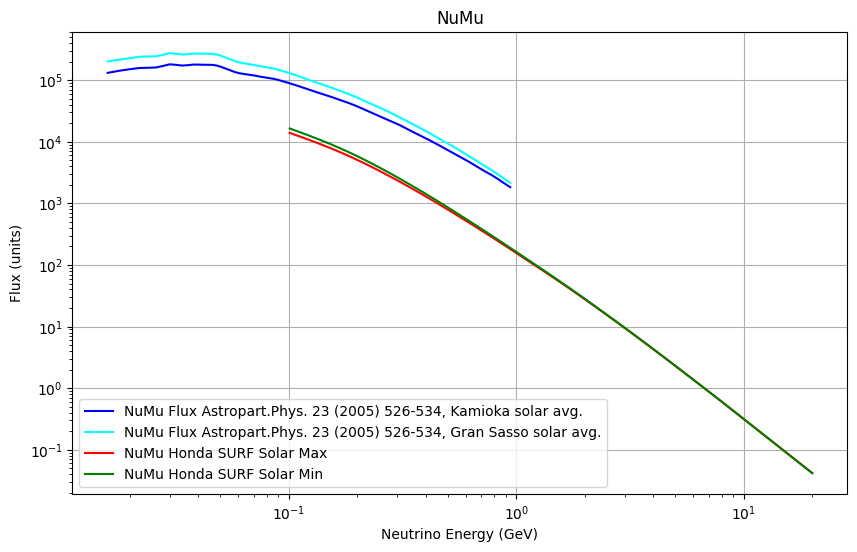

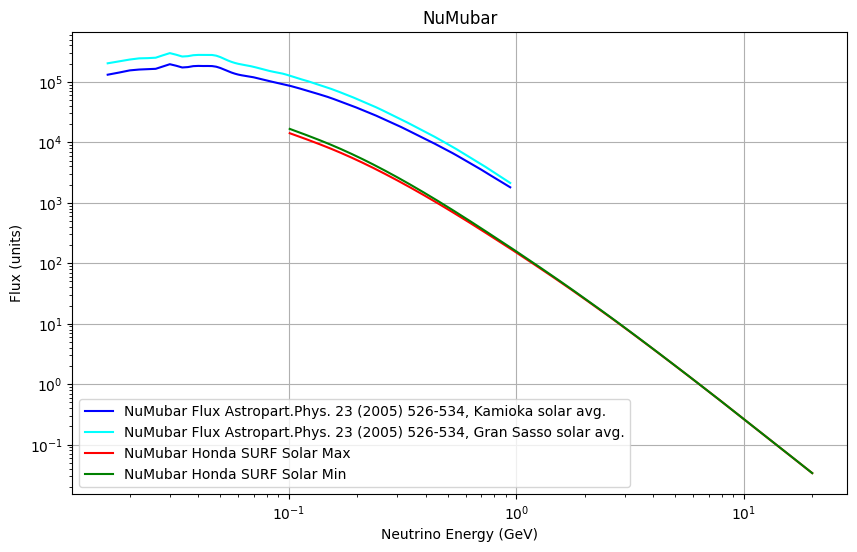

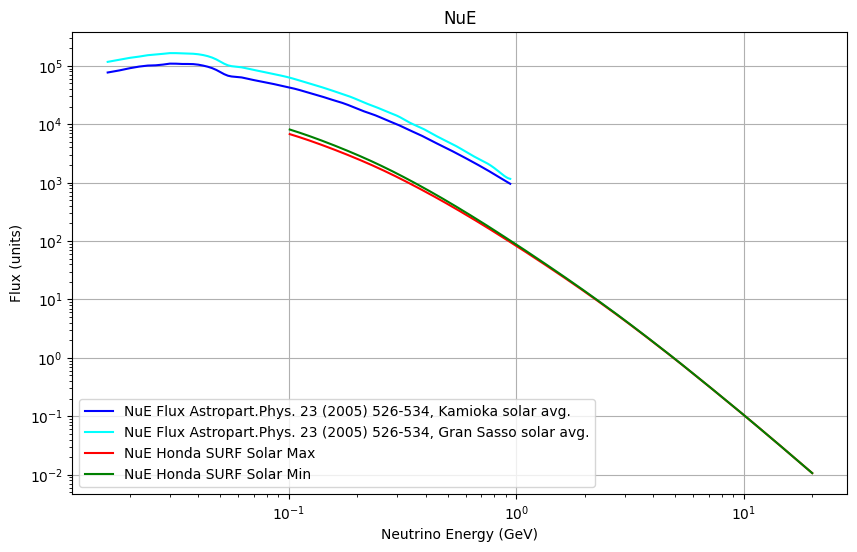

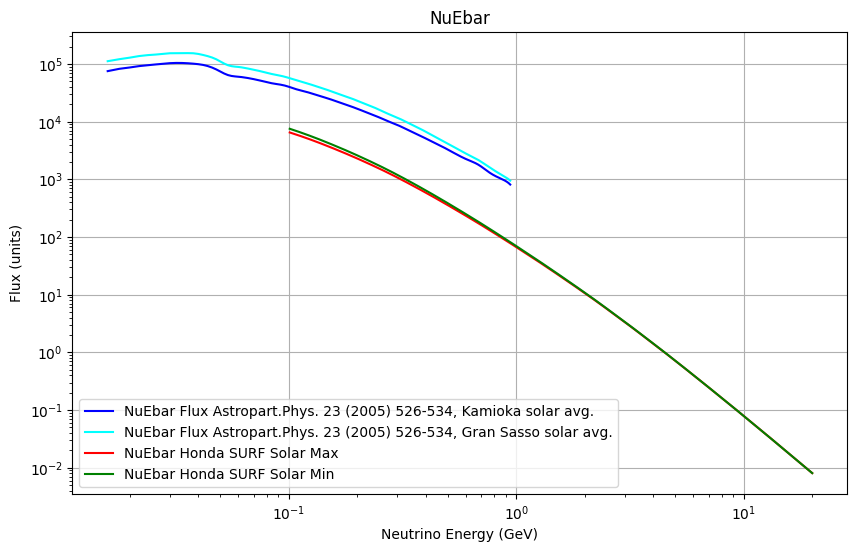

In [18]:
plot_lowE_and_highE(flux_kamioka_numu, flux_gransasso_numu, flux_arr_solar_max[0], flux_arr_solar_max[1], flux_arr_solar_min[0], flux_arr_solar_min[1], 'NuMu', 'Kamioka', 'Gran Sasso')
plot_lowE_and_highE(flux_kamioka_numubar, flux_gransasso_numubar, flux_arr_solar_max[0], flux_arr_solar_max[2], flux_arr_solar_min[0], flux_arr_solar_min[2], 'NuMubar', 'Kamioka', 'Gran Sasso')
plot_lowE_and_highE(flux_kamioka_nue, flux_gransasso_nue, flux_arr_solar_max[0], flux_arr_solar_max[3], flux_arr_solar_min[0], flux_arr_solar_min[3], 'NuE', 'Kamioka', 'Gran Sasso')
plot_lowE_and_highE(flux_kamioka_nuebar, flux_gransasso_nuebar, flux_arr_solar_max[0], flux_arr_solar_max[4], flux_arr_solar_min[0], flux_arr_solar_min[4], 'NuEbar', 'Kamioka', 'Gran Sasso')    

### 5) Save flux into ROOT as TH1D

In [19]:
def save_flux_to_root(E_nu, flux_numu, flux_numubar, flux_nue, flux_nuebar, filename="fluxka_low_e.root"):
    # centers is index 0 (length 200)
    centers = np.array(E_nu)
    flavors = ["numu", "numubar", "nue", "nuebar"]
    flux_data = [E_nu, flux_numu, flux_numubar, flux_nue, flux_nuebar]
    # 1. Calculate the uniform bin width
    # In uniform binning, any two adjacent centers give the width
    bin_width = centers[1] - centers[0]
    
    # 2. Create the edges array (length 201)
    # The first edge is half a width below the first center
    start_edge = centers[0] - (bin_width / 2.0)
    # The last edge is half a width above the last center
    end_edge = centers[-1] + (bin_width / 2.0)
    
    # Generate 201 evenly spaced edges from start to end
    edges = np.linspace(start_edge, end_edge, len(centers) + 1)

    with uproot.recreate(filename) as f:
        for i, name in enumerate(flavors, start=1):
            flux_values = np.array(flux_data[i])
            
            # Write as TH1D: (counts, edges)
            f[name] = (flux_values, edges)
            
    print(f"File '{filename}' created successfully.")
    print(f"Bin width: {bin_width:.4f}, Range: [{edges[0]:.2f}, {edges[-1]:.2f}]")

In [20]:
save_flux_to_root(flux_kamioka_numu[0], flux_kamioka_numu[1], flux_kamioka_numubar[1], flux_kamioka_nue[1], flux_kamioka_nuebar[1], filename="fluka_lowE_kamioka_solar_avg.root")
save_flux_to_root(flux_gransasso_numu[0], flux_gransasso_numu[1], flux_gransasso_numubar[1], flux_gransasso_nue[1], flux_gransasso_nuebar[1], filename="fluka_lowE_gransasso_solar_avg.root")

File 'fluka_lowE_kamioka_solar_avg.root' created successfully.
Bin width: 0.0020, Range: [0.02, 0.94]
File 'fluka_lowE_gransasso_solar_avg.root' created successfully.
Bin width: 0.0020, Range: [0.02, 0.94]
